In [1]:
%matplotlib inline

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Tensorflow
from tensorflow import keras 
import tensorflow as tf

# progress bar
from tqdm import tqdm
import lightgbm as lgb

from csef.utils import performance

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [2]:
data_path = Path('..', '..', 'data', 'raw')
consumption_train = pd.read_csv(data_path / 'consumption_train.csv', 
                                index_col=0, parse_dates=['timestamp'])
cold_start_test = pd.read_csv(data_path / 'cold_start_test.csv', 
                              index_col=0, parse_dates=['timestamp'])
submission_format = pd.read_csv(data_path / 'submission_format.csv',
                                index_col='pred_id',
                                parse_dates=['timestamp'])

meta = pd.read_csv(data_path / 'meta.csv')

In [3]:
def preprocessing(df, category_cols, meta):
    train = df.copy()
    
    train = df.merge(meta, how = 'left', on = ['series_id'])
    
    train = train.set_index('timestamp')
    
    train['hour'] = train.index.hour
    train['wday'] = train.index.dayofweek
    train['mday'] = train.index.day
    train['yday'] = train.index.dayofyear
    train['month'] = train.index.month
    train['year'] = train.index.year
    
    # Cyclical variable transformations
    
    # wday has period of 6
    train['wday_sin'] = np.sin(2 * np.pi * train['wday'] / 6)
    train['wday_cos'] = np.cos(2 * np.pi * train['wday'] / 6)

    # yday has period of 365
    train['yday_sin'] = np.sin(2 * np.pi * train['yday'] / 365)
    train['yday_cos'] = np.cos(2 * np.pi * train['yday'] / 365)

    # month has period of 12
    train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
    train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)

    # time has period of 24
    train['time_sin'] = np.sin(2 * np.pi * train['hour'] / 24)
    train['time_cos'] = np.cos(2 * np.pi * train['hour'] / 24)

    # turn the index into a column
    train = train.reset_index(level=0)
    
    for col in category_cols:
        encoder = LabelEncoder()
        train[col] = encoder.fit_transform(train[col])
        
    return train

def prepare_temp_df(df):
    # remove nan data
    return df.dropna(subset=['temperature'])

def predict_temp(df):
    train = preprocessing(df, category_cols, meta)
    return model.predict(train.drop(columns=['timestamp', 'series_id', 'temperature']))

In [4]:
category_cols = [
    'surface', 'base_temperature', 'monday_is_day_off', 'tuesday_is_day_off', 'wednesday_is_day_off',
    'thursday_is_day_off', 'friday_is_day_off', 'saturday_is_day_off', 'sunday_is_day_off'
]

consumption_processed = preprocessing(consumption_train, category_cols, meta)
cold_start_processed = preprocessing(cold_start_test, category_cols, meta)
submission_processed = preprocessing(submission_format, category_cols, meta)

In [5]:
consumption_ntemp = prepare_temp_df(consumption_processed)
cold_ntemp = prepare_temp_df(cold_start_processed)
submission_ntemp = prepare_temp_df(submission_processed)

In [6]:
full_train = consumption_ntemp.append(cold_ntemp)

In [7]:
full_train.shape

(347755, 27)

In [8]:
full_train.head()

,timestamp,series_id,consumption,temperature,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,...,month,year,wday_sin,wday_cos,yday_sin,yday_cos,month_sin,month_cos,time_sin,time_cos
161,2014-12-30 17:00:00,103088,143709.717612,-4.675,4,1,0,0,0,0,...,12,2014,0.866025,0.5,-1.721336e-02,0.999852,-2.449294e-16,1.0,-0.965926,-2.588190e-01
162,2014-12-30 18:00:00,103088,157424.927949,-5.000,4,1,0,0,0,0,...,12,2014,0.866025,0.5,-1.721336e-02,0.999852,-2.449294e-16,1.0,-1.000000,-1.836970e-16
182,2014-12-31 14:00:00,103088,153370.363034,-4.400,4,1,0,0,0,0,...,12,2014,0.866025,-0.5,6.432491e-16,1.000000,-2.449294e-16,1.0,-0.500000,-8.660254e-01
183,2014-12-31 15:00:00,103088,137602.089769,-4.650,4,1,0,0,0,0,...,12,2014,0.866025,-0.5,6.432491e-16,1.000000,-2.449294e-16,1.0,-0.707107,-7.071068e-01
184,2014-12-31 16:00:00,103088,131771.016064,-5.100,4,1,0,0,0,0,...,12,2014,0.866025,-0.5,6.432491e-16,1.000000,-2.449294e-16,1.0,-0.866025,-5.000000e-01


Merge meta to the full train

In [9]:
X = full_train.drop(columns=['timestamp', 'series_id', 'temperature'])
y = full_train.temperature

In [10]:
X.columns

Index(['consumption', 'surface', 'base_temperature', 'monday_is_day_off',
       'tuesday_is_day_off', 'wednesday_is_day_off', 'thursday_is_day_off',
       'friday_is_day_off', 'saturday_is_day_off', 'sunday_is_day_off', 'hour',
       'wday', 'mday', 'yday', 'month', 'year', 'wday_sin', 'wday_cos',
       'yday_sin', 'yday_cos', 'month_sin', 'month_cos', 'time_sin',
       'time_cos'],
      dtype='object')

In [11]:
X.head()

,consumption,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,...,month,year,wday_sin,wday_cos,yday_sin,yday_cos,month_sin,month_cos,time_sin,time_cos
161,143709.717612,4,1,0,0,0,0,0,1,1,...,12,2014,0.866025,0.5,-1.721336e-02,0.999852,-2.449294e-16,1.0,-0.965926,-2.588190e-01
162,157424.927949,4,1,0,0,0,0,0,1,1,...,12,2014,0.866025,0.5,-1.721336e-02,0.999852,-2.449294e-16,1.0,-1.000000,-1.836970e-16
182,153370.363034,4,1,0,0,0,0,0,1,1,...,12,2014,0.866025,-0.5,6.432491e-16,1.000000,-2.449294e-16,1.0,-0.500000,-8.660254e-01
183,137602.089769,4,1,0,0,0,0,0,1,1,...,12,2014,0.866025,-0.5,6.432491e-16,1.000000,-2.449294e-16,1.0,-0.707107,-7.071068e-01
184,131771.016064,4,1,0,0,0,0,0,1,1,...,12,2014,0.866025,-0.5,6.432491e-16,1.000000,-2.449294e-16,1.0,-0.866025,-5.000000e-01


In [18]:
X.dtypes

consumption             float64
surface                   int64
base_temperature          int64
monday_is_day_off         int64
tuesday_is_day_off        int64
wednesday_is_day_off      int64
thursday_is_day_off       int64
friday_is_day_off         int64
saturday_is_day_off       int64
sunday_is_day_off         int64
hour                      int64
wday                      int64
mday                      int64
yday                      int64
month                     int64
year                      int64
wday_sin                float64
wday_cos                float64
yday_sin                float64
yday_cos                float64
month_sin               float64
month_cos               float64
time_sin                float64
time_cos                float64
dtype: object

In [17]:
y.head()

161   -4.675
162   -5.000
182   -4.400
183   -4.650
184   -5.100
Name: temperature, dtype: float64

### Optimize model

Make the LGB regressor to predict the temperature

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV

In [23]:
lgb_grid = {'boosting_type' : ['gbdt'],
  'learning_rate' : [0.02, 0.03, 0.04],
  'bagging_freq' : [1, 2, 3, 5, ],
  'feature_fraction' : [0.8,0.9,1.0],
  'bagging_fraction' : [0.9, 0.95, 1.0],
  'max_depth' : [6,7,8,10],
  'num_leaves' : [7, 15, 31, 63],
  'min_data_in_leaf' : [1, 10, 20, 30, 50, 70],
  'max_bin' : [127, 255, 511],
  'my_skip_first' : [0.6, 0.7, 0.8]}

In [24]:
mdl = lgb.LGBMRegressor(boosting_type='gbdt', n_jobs = 6, silent = True)

In [25]:
grid = GridSearchCV(mdl, lgb_grid, verbose=0, cv=4, n_jobs=2)

In [ ]:
grid.fit(X, y)

In [27]:
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [17]:
model.fit(X, y, verbose=1, categorical_feature=category_cols)

/home/thuongdinh/.virtualenvs/mlcsef/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['base_temperature', 'friday_is_day_off', 'monday_is_day_off', 'saturday_is_day_off', 'sunday_is_day_off', 'surface', 'thursday_is_day_off', 'tuesday_is_day_off', 'wednesday_is_day_off']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [18]:
mean_squared_error(y, model.predict(X))

13.889488634493057

In [32]:
na_temp_train = consumption_train[np.isnan(consumption_train.temperature)]
na_temp_col = cold_start_test[np.isnan(cold_start_test.temperature)]
na_temp_subs = submission_format[np.isnan(submission_format.temperature)]

In [56]:
consumption_train.loc[na_temp_train.index, 'temperature'] = predict_temp(na_temp_train)
cold_start_test.loc[na_temp_col.index, 'temperature'] = predict_temp(na_temp_col)

In [59]:
consumption_train.head()

,series_id,timestamp,consumption,temperature
0,103088,2014-12-24 00:00:00,101842.233424,8.249142
1,103088,2014-12-24 01:00:00,105878.048906,8.219179
2,103088,2014-12-24 02:00:00,91619.105008,8.080098
3,103088,2014-12-24 03:00:00,94473.706203,7.758540
4,103088,2014-12-24 04:00:00,96976.755526,7.717005


In [60]:
consumption_train.to_csv(data_path / 'consumption_train_fix_temp.csv')
cold_start_test.to_csv(data_path / 'cold_start_test_temp.csv')

## Features

In [68]:
from sklearn.preprocessing import MinMaxScaler

def create_lagged_features(df, cols, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=cols)
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        for col in cols:
            df = df.join(df[col].shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

def prepare_training_data(df, cols, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    
    scalers = {}
    
    # scale training data
    df_vals = df.copy()
    for col in cols:
        scalers[col] = MinMaxScaler(feature_range=(-1, 1))
        df_vals[col] = scalers[col].fit_transform(df[col].values.reshape(-1, 1))

    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(df_vals, cols, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop(cols, axis=1).values
    y = consumption_lagged[cols].values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scalers

In [61]:
sample_ser = (consumption_train
                           .series_id
                           .sample().values[0])
sample_ser = 100025
sample_df = consumption_train[consumption_train.series_id == sample_ser]
sample_cold_df = cold_start_test[cold_start_test.series_id == sample_ser]
sample_subs_df = submission_format[submission_format.series_id == sample_ser]

In [62]:
sample_df.head(100)

,series_id,timestamp,consumption,temperature
14112,100025,2015-01-06 00:00:00,224223.214731,9.913043
14113,100025,2015-01-06 01:00:00,195686.338895,9.840936
14114,100025,2015-01-06 02:00:00,217511.281110,9.382517
14115,100025,2015-01-06 03:00:00,196026.227094,9.436780
14116,100025,2015-01-06 04:00:00,217133.627556,9.314447
14117,100025,2015-01-06 05:00:00,207633.924062,8.520787
14118,100025,2015-01-06 06:00:00,195130.158206,8.520787
14119,100025,2015-01-06 07:00:00,236692.648446,8.273646
14120,100025,2015-01-06 08:00:00,231662.989748,8.941600
14121,100025,2015-01-06 09:00:00,212055.903860,10.138492


## Model fitting

In [69]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
cols = ['consumption', 'temperature']
n_cols = len(cols)
n_features = n_cols
lag = 24

# model parameters
num_neurons = lag * n_cols
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag * n_cols)

# instantiate a sequential model
model = keras.Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(keras.layers.LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(keras.layers.Dense(n_features))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [70]:
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

total_timer = performance.Timer()

epoch_timers = []

num_sers = consumption_train['series_id'].nunique()

callbacks = [
  # Write TensorBoard logs to `./logs` directory
  keras.callbacks.TensorBoard(log_dir='./logs')
]

for i in range(num_passes_through_data):
    
    epoch_timer = performance.Timer()
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in tqdm(consumption_train.groupby('series_id'),
                                 total=num_sers,
                                 desc='Learning Consumption Trends - Epoch'):

        # prepare the data
        X, y, scalers = prepare_training_data(ser_data[cols], cols, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=callbacks)
        model.reset_states()
    
    epoch_timers.append(epoch_timer)
    
    print(f'Finish an epoch in {epoch_timer.get_time()}')

total_end_timer = performance.Timer()

Learning Consumption Trends - Epoch:   0%|          | 0/758 [00:00<?, ?it/s]

Finish an epoch in 00:25:27


Learning Consumption Trends - Epoch:   0%|          | 0/758 [00:00<?, ?it/s]

Finish an epoch in 00:25:24


Learning Consumption Trends - Epoch: 100%|██████████| 758/758 [25:24<00:00,  2.03s/it]

Finish an epoch in 00:25:24


In [71]:
epoch_timers

In [72]:
model.save('../../data/model/multivariate-lstm-20181029-01.hdf5')

## Predict 

In [74]:
# model2 = keras.models.load_model('../../data/model/multivariate-lstm-20181023-02.hdf5')
my_submission = submission_format.copy()

In [82]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scalers, lag, cols):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = consumption[cols].copy()
    X = X.tail(lag)
    for col in cols:
        X[col] = scalers[col].transform(X[col].values.reshape(-1, 1))
        
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.values.reshape(1, 1, lag*n_cols), batch_size=1)[0]
        preds_scaled[i] = yhat[0]
        
        # update X to be latest data plus prediction
        col_0 = pd.Series(X[cols[0]].values.ravel(), name=cols[0]).shift(-1).fillna(yhat[0])
        col_1 = pd.Series(X[cols[1]].values.ravel(), name=cols[1]).shift(-1).fillna(yhat[1])
        X = pd.concat([col_0, col_1], axis=1)
        
    # revert scale back to original range
    hourly_preds = scalers[cols[0]].inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [83]:
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = cold_start_test[cold_start_test.series_id == ser_id][cols]
    series_data = series_data.fillna(0)
    
    cold_X, cold_y, scalers = prepare_training_data(series_data, cols, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scalers, lag, cols)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

Forecasting from Cold Start Data: 100%|██████████| 625/625 [09:16<00:00,  1.05it/s]


In [84]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

count    5.808000e+03
mean     1.653070e+05
std      6.171911e+05
min     -2.365379e+04
25%      1.573037e+04
50%      3.615480e+04
75%      9.206244e+04
max      5.129302e+06
Name: consumption, dtype: float64

In [85]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

count    1.337000e+03
mean     3.311236e+06
std      9.836856e+06
min      4.138786e+03
25%      3.723242e+05
50%      8.529529e+05
75%      2.605896e+06
max      1.177419e+08
Name: consumption, dtype: float64

In [86]:
my_submission[my_submission.prediction_window == 'weekly'].consumption.describe()

count    3.840000e+02
mean     2.345907e+07
std      6.421514e+07
min      2.312850e+04
25%      3.121002e+06
50%      7.052239e+06
75%      1.991420e+07
max      7.337824e+08
Name: consumption, dtype: float64

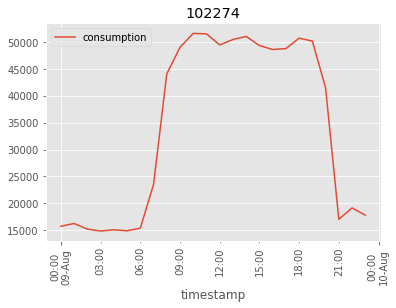

In [87]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [88]:
my_submission.head(5)

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,345808.950661,daily
1,102781,2013-03-04,20.034375,342498.206407,daily
2,102781,2013-03-05,19.189583,343765.076803,daily
3,102781,2013-03-06,18.397917,345448.931048,daily
4,102781,2013-03-07,20.762500,345338.841353,daily


In [89]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)

my_submission.to_csv(save_path / "multivariate-20181029.csv", index_label='pred_id')

The result is xxxx